# Making All the Necessary Imports and Preparing the Dataset



In [ ]:
#Imports
import librosa
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import os
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib.pyplot as plt
from librosa import display


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Preparing the Dataset

#clean dataset
data_path = "drive/MyDrive/Dataset Project 1/speech algorithm classification dataset/algorithm classification dataset"
data_folder = os.walk(data_path)
aud_list = []
classes_list = []
file = open(data_path + '/'+'labels.csv')
csvreader = csv.reader(file)
csv_list=[]
for row in csvreader:
  csv_list.append(row)
file.close()

for (root,dirs,files) in data_folder:
  for name in files:
    if name != "labels.csv":   
      aud = (data_path+'/'+name)
      for x in csv_list:
        if x[0]==name:
          classes_list.append(x[1])
          aud_list.append(aud)
          break

#augmented dataset
def nameParser(filename):
  if (filename[-10:-4])=="_noise":
    file2 = filename.replace("_noise","")
    return file2
  if (filename[-11:-4])=="_reverb":
    file2 = filename.replace("_reverb","")
    return file2
  if(filename[-15:-4])=="_compressed":
    file2 = filename.replace("_compressed","")
    return file2

data_path = "drive/MyDrive/Dataset Project 1/augmented_training_data/augmented_training_data"
data_folder = os.walk(data_path)

file = open(data_path + '/'+'labels.csv')
csvreader = csv.reader(file)
csv_list=[]
for row in csvreader:
  csv_list.append(row)
file.close()

for (root,dirs,files) in data_folder:
  for name in files:
    if name != "labels.csv" and name!="label_description.txt":   
      aud = (data_path+'/'+name)
      name2 = nameParser(name)
      for x in csv_list:
        if x[0]==name2:
          classes_list.append(x[1])
          aud_list.append(aud)
          break




# Extracting Features


Extracting

In [ ]:
mfcc_list = []
chroma_list = []
spectral_centroid=[]

for idx,aud in enumerate(aud_list):
  print(idx)
  signal, sr = librosa.load(aud)
  signal = signal.flatten()
  mfccs = librosa.feature.mfcc(signal, n_mfcc=13,sr=sr) #extracting mfccs
  #now for delta and delta2 mfccs
  delta_mfcc = librosa.feature.delta(mfccs) #the delta features show how the signals vary with time, will be useful for stuff like handling reverb audio
  delta2_mfcc=librosa.feature.delta(mfccs,order=2)
  final_mfcc = np.concatenate((mfccs,delta_mfcc,delta2_mfcc))
  #scaling
  final_scaled=np.mean(final_mfcc.T,axis=0) #Scaled features, 
  mfcc_list.append(final_scaled)
  chroma_cq = librosa.feature.chroma_stft(y=signal, sr=sr, n_fft=4096) #extracting chroma stft
  chroma_cq = np.mean(chroma_cq.T,axis=0)
  chroma_list.append(chroma_cq)
  cent = librosa.feature.spectral_centroid(y=signal, sr=sr) #extracting spectral centroid
  cent = np.mean(cent.T,axis=0)
  spectral_centroid.append(cent)




In [ ]:
from pathlib import Path

path = Path('/content/drive/MyDrive/').expanduser()
# np.save(path/'mfcc_list.npy',mfcc_list)
# np.save(path/'chroma_list.npy',chroma_list)
# np.save(path/'spectral_centroid.npy',spectral_centroid)

mfcc_list =np.load(path/'mfcc_list.npy')
mfcc_list = np.array(mfcc_list,dtype=float)
chroma_list =np.load(path/'chroma_list.npy')
chroma_list = np.array(chroma_list,dtype=float)
spectral_centroid =np.load(path/'spectral_centroid.npy')
spectral_centroid = np.array(spectral_centroid,dtype=float)

# Principle Component Analysis and Train Test Split
The purpose of PCA in our project is for dimensionality reduction, for example, MFCCs with 39 dimensions is alot for ML algorithms and running them would be too slow 
It is to be noted that we could just run PCA on the entirity of the combined dataset, however, we wanted to be thorough with our project and we wanted to find the features that are best suited for synthetic algorithm classification


In [ ]:
# First, we generate 1000 random numbers for train test split 
import random

random_ints = random.sample(range(4999), 1000)
total_ints = list(range(0,5000))
split_ints =[]
for inte in total_ints:
  if inte not in random_ints:
    split_ints.append(inte)

  
def splitter(list_numbers,data,split_int):
  test_data = []
  train_data=[]
  for x in list_numbers:
    test_data.append(data[x])
  for x in split_int:
    train_data.append(data[x])
  return (test_data,train_data)

#Train Test Split for Clean Dataset 
mfcc_clean = mfcc_list[0:5000]
mfcc_clean_test, mfcc_clean_train = splitter(random_ints,mfcc_clean,split_ints) 
spectral_centroid_clean = spectral_centroid[0:5000]
spec_test_clean, spec_train_clean = splitter(random_ints,spectral_centroid_clean,split_ints)
chroma_list_clean = chroma_list[0:5000]
chroma_test_clean, chroma_train_clean = splitter(random_ints,chroma_list_clean,split_ints)
classes_list_clean = classes_list[0:5000]
classes_test_clean,classes_train_clean = splitter(random_ints,classes_list_clean,split_ints)
classes_test1 = classes_test_clean
classes_train1= classes_train_clean

print("original MFCC feature")
print((mfcc_clean_test[0].shape))
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(mfcc_clean_train)
mfcc_clean_train_scaled = scaler.transform(mfcc_clean_train)
print(mfcc_clean_train_scaled[0])
mfcc_clean_test_scaled = scaler.transform(mfcc_clean_test)
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(mfcc_clean_train_scaled)
mfcc_train1 = pca.transform(mfcc_clean_train_scaled)
mfcc_test1 = pca.transform(mfcc_clean_test_scaled)
print("After mfcc shape")
print(mfcc_train1[0].shape)

print("original spec feature")
print((spec_train_clean[0].shape)) # Since the shape is already 1, no need to perform PCA
print("Shape already 1, no need to use PCA")
spec_train1 = spec_train_clean
spec_test1 = spec_test_clean
print("Original chroma feature")
print(chroma_list_clean[0].shape)
scaler = preprocessing.StandardScaler().fit(chroma_train_clean)
chroma_train_clean = scaler.transform(chroma_train_clean)
chroma_test_clean = scaler.transform(chroma_test_clean)

pca = PCA(n_components = 0.95)
pca.fit(chroma_train_clean)
chroma_train1 = pca.transform(chroma_train_clean)
chroma_test1 = pca.transform(chroma_test_clean)

print("after chroma feature")
print((chroma_train1[0].shape))



original MFCC feature
(39,)
[ 0.31901409  0.80557885 -0.71843114 -2.63884379 -0.71775287 -1.37953025
 -0.79901857  0.33119299  0.15469196 -2.23657344 -0.69026627 -0.1549199
 -0.81307402 -1.4391462  -1.1088326   1.15401263 -1.86353729 -0.03662859
  3.42827634  1.58921954  0.37540076  0.14262442  2.89307787  2.21747835
 -1.7092008   1.96582908 -0.45435254  0.14373532  0.65247269  0.63845262
  0.66299556 -0.63729872  0.77948307 -0.53870603  0.52724585  0.25550433
  1.22820273  2.64746713  1.2592844 ]
After mfcc shape
(26,)
original spec feature
(1,)
Shape already 1, no need to use PCA
Original chroma feature
(12,)
after chroma feature
(7,)


In [ ]:
# Augmented Dataset and Clean Dataset Combined
random_ints = random.sample(range(19999), 4000)
total_ints = list(range(0,20000))
split_ints =[]
for inte in total_ints:
  if inte not in random_ints:
    split_ints.append(inte)

mfcc_clean_test, mfcc_clean_train = splitter(random_ints,mfcc_list,split_ints) 
spec_test_clean, spec_train_clean = splitter(random_ints,spectral_centroid,split_ints)
chroma_test_clean, chroma_train_clean = splitter(random_ints,chroma_list,split_ints)
classes_test_clean,classes_train_clean = splitter(random_ints,classes_list,split_ints)
classes_test2 = classes_test_clean
classes_train2 = classes_train_clean

print("original MFCC feature")
print((mfcc_clean_test[0].shape))
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(mfcc_clean_train)
mfcc_clean_train_scaled = scaler.transform(mfcc_clean_train)
mfcc_clean_test_scaled = scaler.transform(mfcc_clean_test)
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(mfcc_clean_train_scaled)
mfcc_train2 = pca.transform(mfcc_clean_train_scaled)
mfcc_test2 = pca.transform(mfcc_clean_test_scaled)
print("After mfcc shape")
print(mfcc_train2[0].shape)

print("original spec feature")
print((spec_train_clean[0].shape)) # Since the shape is already 1, no need to perform PCA
print("Shape already 1, no need to use PCA")
spec_train2 = spec_train_clean
spec_test2 = spec_test_clean
print("Original chroma feature")
print(chroma_list_clean[0].shape)
scaler = preprocessing.StandardScaler().fit(chroma_train_clean)
chroma_train_clean = scaler.transform(chroma_train_clean)
chroma_test_clean = scaler.transform(chroma_test_clean)

pca = PCA(n_components = 0.95)
pca.fit(chroma_train_clean)
chroma_train2 = pca.transform(chroma_train_clean)
chroma_test2 = pca.transform(chroma_test_clean)

print("after chroma feature")
print((chroma_train1[0].shape))



original MFCC feature
(39,)
After mfcc shape
(26,)
original spec feature
(1,)
Shape already 1, no need to use PCA
Original chroma feature
(12,)
after chroma feature
(7,)


Creating All Possible Datasets for Feature Selection


In [ ]:
#mfcc,spec,chroma,mfcc_spec,mfcc_chroma,chroma_spec,mfccs_spec_chroma

mfcc_chroma=[] #mfcc chroma
mfcc_spec = [] #mfcc spec
chroma_spec =[] # chroma spec
mfcc_spec_chroma=[] # mfcc spec chroma

def maker(mfcc_lister,spec_lister,chroma_lister):
  mfcc_chroma=[] #mfcc chroma
  mfcc_spec = [] #mfcc spec
  chroma_spec =[] # chroma spec
  mfcc_spec_chroma=[] # mfcc spec chroma
  for x in range(len(mfcc_lister)):
    finale=[]
    finale = np.concatenate((mfcc_lister[x],chroma_lister[x]))
    mfcc_chroma.append(finale)
    finale=[]
    finale = np.concatenate((mfcc_lister[x],spec_lister[x]))
    mfcc_spec.append(finale)
    finale=[]
    finale = np.concatenate((chroma_lister[x],spec_lister[x]))
    chroma_spec.append(finale)
    finale=[]
    finale = np.concatenate((mfcc_lister[x],spec_lister[x],chroma_lister[x]))
    mfcc_spec_chroma.append(finale)
  return mfcc_chroma,mfcc_spec,chroma_spec,mfcc_spec_chroma

mfcc_chroma_train1,mfcc_spec_train1,chroma_spec_train1,mfcc_spec_chroma_train1 = maker(mfcc_train1,spec_train1,chroma_train1)
mfcc_chroma_train2,mfcc_spec_train2,chroma_spec_train2,mfcc_spec_chroma_train2 = maker(mfcc_train2,spec_train2,chroma_train2)
mfcc_chroma_test1,mfcc_spec_test1,chroma_spec_test1,mfcc_spec_chroma_test1 = maker(mfcc_test1,spec_test1,chroma_test1)
mfcc_chroma_test2,mfcc_spec_test2,chroma_spec_test2,mfcc_spec_chroma_test2 = maker(mfcc_test2,spec_test2,chroma_test2)


features1 = [("MFCCs",mfcc_train1,mfcc_test1),("Chroma",chroma_train1,chroma_test1),("Spec",spec_train1,spec_test1),("MFCCs+Chroma",mfcc_chroma_train1,mfcc_chroma_test1),("MFCCs+Spec",mfcc_spec_train1,mfcc_spec_test1),("Spec+Chroma",chroma_spec_train1,chroma_spec_test1),("MFCCs+Spec+Chroma",mfcc_spec_chroma_train1,mfcc_spec_chroma_test1)]

features2 = [("MFCCs",mfcc_train2,mfcc_test2),("Chroma",chroma_train2,chroma_test2),("Spec",spec_train2,spec_test2),("MFCCs+Chroma",mfcc_chroma_train2,mfcc_chroma_test2),("MFCCs+Spec",mfcc_spec_train2,mfcc_spec_test2),("Spec+Chroma",chroma_spec_train2,chroma_spec_test2),("MFCCs+Spec+Chroma",mfcc_spec_chroma_train2,mfcc_spec_chroma_test2)]



# KNN Implementation
Finding the best parameters using gridsearchCV

In [ ]:
from sklearn.metrics import classification_report

def KnnImplementation(X_train,X_test,y_train,y_test):  
  knn = (KNeighborsClassifier())
  parameters = {
      'n_neighbors' :[1,3,5,7,9,11,13,15,17,19,21,23,25,27,29],
      'p' :[1,2],
      'algorithm':['auto']
  }

  final = GridSearchCV(estimator = (KNeighborsClassifier()),param_grid=parameters,scoring='accuracy',cv=10)
  final2 = final.fit(X_train,y_train)

  if final2.best_params_['p']==1:
    best_dis = "Manhattan"
  if final2.best_params_['p']==2:
    best_dis = "Euclidean"


  knn = (KNeighborsClassifier (n_neighbors = final2.best_params_['n_neighbors'],p=final2.best_params_['p'],algorithm = 'brute'))
  knn.fit(X_train,y_train)

  predict_list= knn.predict(X_test)

  acc_score = accuracy_score(y_test,predict_list)

  f1_scor = f1_score(y_test,predict_list,average='macro')
  report = classification_report(y_test,predict_list)

  return((acc_score,best_dis,final2.best_params_['n_neighbors'],'KNN',report))

#For the Clean Dataset 
result_list = []
for x in features1:
  x_train = x[1]
  x_test = x[2]
  res = KnnImplementation(x_train,x_test,classes_train1,classes_test1)
  result_list.append(res)
#For augmented
result_list2 = []
for x in features2:
  x_train = x[1]
  x_test = x[2]
  res = KnnImplementation(x_train,x_test,classes_train2,classes_test2)
  result_list2.append(res)




For Clean Dataset

[0.866, 0.856, 0.432, 0.936, 0.715, 0.77, 0.802]


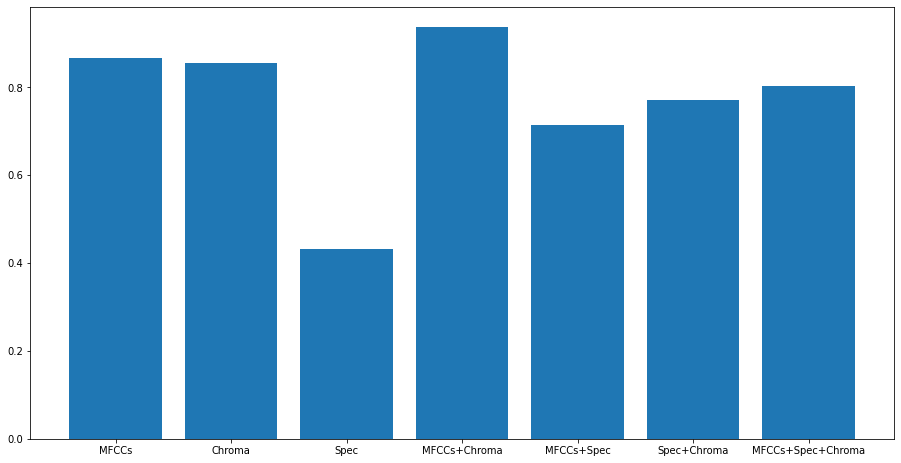

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features1]
accuracy_list = [x[0] for x in result_list]
print(accuracy_list)

ax.bar(features,accuracy_list)
plt.show()



We see that MFCC+Chroma work best together in terms of accuracy, so now we look at its metrics

In [ ]:
print(features1[3][0])
print("The Best number of K Neighbors for Clean Dataset KNN using ",result_list[3][1]," distance: ",result_list[3][2],"with an accuracy of: ",max(accuracy_list))
print(result_list[3][-1])

MFCCs+Chroma
The Best number of K Neighbors for Clean Dataset KNN using  Manhattan  distance:  5 with an accuracy of:  0.936
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       208
           1       0.84      0.89      0.86       202
           2       0.87      0.78      0.82       170
           3       0.97      0.99      0.98       217
           4       1.00      1.00      1.00       203

    accuracy                           0.94      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.94      0.94      0.94      1000



For Clean and Augmented Dataset combined


[0.945, 0.91525, 0.6075, 0.96775, 0.82475, 0.85325, 0.887]


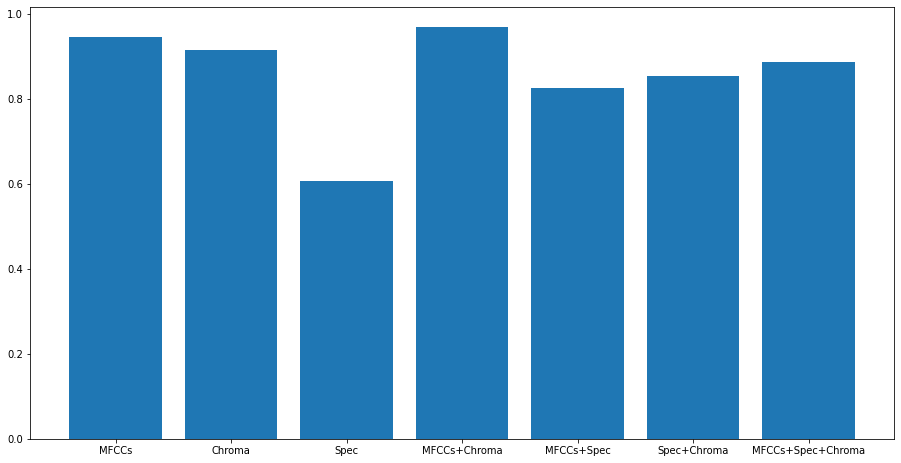

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features2]
accuracy_list = [x[0] for x in result_list2]
print(accuracy_list)

ax.bar(features,accuracy_list)
plt.show()


In [ ]:

print(features2[3][0])
print("The Best number of K Neighbors for Clean and Augmented Dataset Combined in KNN using ",result_list2[3][1]," distance: ",result_list2[3][2]," with an accuracy of: ",max(accuracy_list))
print(result_list2[3][-1])

MFCCs+Chroma
The Best number of K Neighbors for Clean and Augmented Dataset Combined in KNN using  Manhattan  distance:  1  with an accuracy of:  0.96775
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       816
           1       0.93      0.94      0.93       842
           2       0.94      0.91      0.93       795
           3       0.98      1.00      0.99       772
           4       1.00      0.99      1.00       775

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



# Logistic Regression Implementation


In [ ]:
def LogisticRegressionImplementation(X_train,X_test,y_train,y_test):
  parameters = {
      'penalty' :["l1","l2"],
      'random_state':[0],
      'max_iter':[1000],
      'solver':["liblinear"]
     
  }

  final = GridSearchCV(estimator = LogisticRegression(),param_grid=parameters,scoring='accuracy',cv=5)
  final2 = final.fit(X_train,y_train)
  clf = LogisticRegression(random_state=0,max_iter = 1000,solver="liblinear",penalty = final2.best_params_['penalty']).fit(X_train,y_train)
  list_predict = clf.predict(X_test)
  acc_score1 = accuracy_score(y_test,list_predict)

  parameters2= {
      'penalty':["elasticnet"],
      'l1_ratio': np.linspace(0,1,num=10),
      'random_state':[0],
      'max_iter':[1000],
      'solver':["saga"],
      'n_jobs':[-1]

  }
  final3 = GridSearchCV(estimator = LogisticRegression(),param_grid=parameters2,scoring='accuracy',cv=5)
  final4 = final3.fit(X_train,y_train)


  clf = LogisticRegression(l1_ratio = final4.best_params_['l1_ratio'],random_state=0,max_iter=1000,penalty='elasticnet',solver='saga',n_jobs=-1).fit(X_train, y_train)
  list_predict = clf.predict(X_test)
  acc_score2 = accuracy_score(y_test,list_predict)
  report = classification_report(y_test,list_predict)
  
  if acc_score1>=acc_score2:
    return ((acc_score1,final2.best_params_['penalty'],'Logistic Regression',report))
  else:
    return ((acc_score2,final4.best_params_['penalty'],final4.best_params_['l1_ratio'],'Elastic Net Logistic Regression',report))


In [ ]:
#For the Clean Dataset 
result_list = []
for x in features1:
  x_train = x[1]
  x_test = x[2]
  res = LogisticRegressionImplementation(x_train,x_test,classes_train1,classes_test1)
  result_list.append(res)
#For augmented
result_list2 = []
for x in features2:
  x_train = x[1]
  x_test = x[2]
  res = LogisticRegressionImplementation(x_train,x_test,classes_train2,classes_test2)
  result_list2.append(res)


For clean dataset


0.948


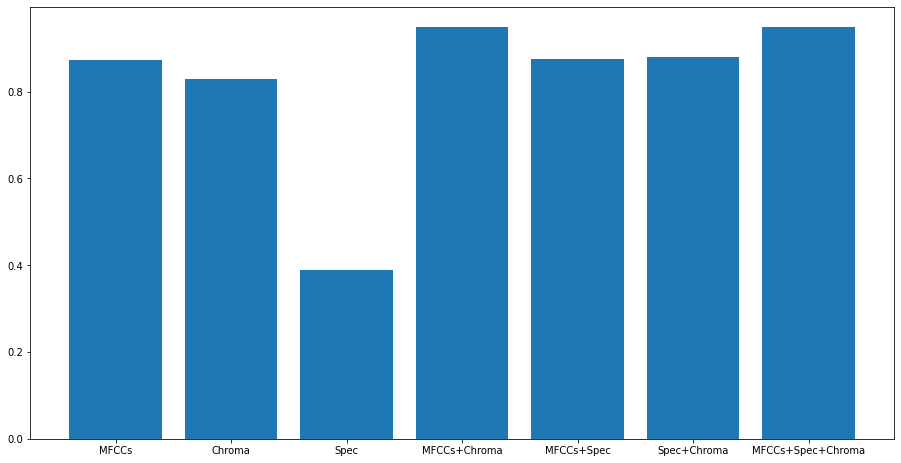

0.948


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features1]
accuracy_list = [x[0] for x in result_list]
print(max(accuracy_list))
ax.bar(features,accuracy_list)
plt.show()



In [ ]:
print("We can see that for Logistic Regression on the clean dataset, MFCC+Chroma and MFCCs+Spec+Chroma seem to work similarly and they return the highest accuracy of ",max(accuracy_list))

print("\nFor",features1[3][0])
print("The classifier used is ",result_list[3][-2]," with the ",result_list[3][-3]," penalty")
print(result_list[3][-1])

print("\nFor",features1[6][0])
print("The classifier used is ",result_list[6][-2]," with the ",result_list[6][-3]," penalty")
print(result_list[6][-1])

print("We can see however that MFCC+SPEC+CHROMA suffers from lower precision,recall and f1 scores as compared to just MFCC+Chroma\nSo these are our selected features for Logistic Regression on the clean dataset")


We can see that for Logistic Regression on the clean dataset, MFCC+Chroma and MFCCs+Spec+Chroma seem to work similarly and they return the highest accuracy of  0.948

For MFCCs+Chroma
The classifier used is  Logistic Regression  with the  l1  penalty
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       0.90      0.85      0.87       202
           2       0.83      0.89      0.86       170
           3       0.99      0.99      0.99       217
           4       1.00      1.00      1.00       203

    accuracy                           0.95      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.95      0.95      0.95      1000


For MFCCs+Spec+Chroma
The classifier used is  Logistic Regression  with the  l1  penalty
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       208
           1       0.85      0.80      0.83       202
       

For Clean and Augmented Dataset Combined

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features2]
accuracy_list = [x[0] for x in result_list2]
print(accuracy_list)
ax.bar(features,accuracy_list)
plt.show()

In [ ]:
print("we can see that for logistic regression on the clean and augmented dataset combined, MFCC and Chroma together work the best with an accuracy of ",max(accuracy_list))
print("\nFor",features2[3][0])
print("The classifier used is ",result_list2[3][-2]," with best tuned parameter l1 ratio: ",result_list2[3][-3])
print(result_list2[3][-1])



we can see that for logistic regression on the clean and augmented dataset combined, MFCC and Chroma together work the best with an accuracy of  0.93075

For MFCCs+Chroma
The classifier used is  Elastic Net Logistic Regression  with best tuned parameter l1 ratio:  0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       816
           1       0.83      0.86      0.85       842
           2       0.85      0.82      0.83       795
           3       0.99      0.98      0.98       772
           4       1.00      1.00      1.00       775

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



# Naive Bayes Implementation

In [ ]:
from sklearn.naive_bayes import GaussianNB

def naiveBayesImplementation(X_train,X_test,y_train,y_test):
  gnb = GaussianNB()

  predict_list= gnb.fit(X_train, y_train).predict(X_test)

  acc_score = accuracy_score(y_test,predict_list)
  report = classification_report(y_test,predict_list)
  return((acc_score,'Naive Bayes',report))




In [ ]:
#For the Clean Dataset 
result_list = []
for x in features1:
  x_train = x[1]
  x_test = x[2]
  res = naiveBayesImplementation(x_train,x_test,classes_train1,classes_test1)
  result_list.append(res)
#For augmented
result_list2 = []
for x in features2:
  x_train = x[1]
  x_test = x[2]
  res = naiveBayesImplementation(x_train,x_test,classes_train2,classes_test2)
  result_list2.append(res)


For Clean Dataset

[0.732, 0.833, 0.433, 0.888, 0.735, 0.863, 0.893]


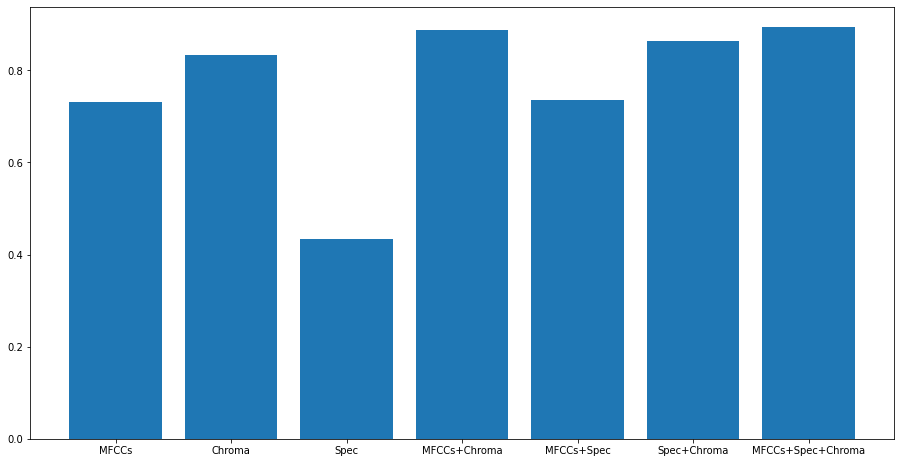

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features1]
accuracy_list = [x[0] for x in result_list]
print((accuracy_list))
ax.bar(features,accuracy_list)
plt.show()

In [ ]:
print("We can see that for Naive Bayes on the clean dataset, MFCC+Chroma and MFCCs+Spec+Chroma seem to work similarly and they return the highest accuracy of ",max(accuracy_list))

print("\nFor",features1[3][0])
print("The classifier used is ",result_list[3][-2]," with accuracy ",result_list[3][-3])
print(result_list[3][-1])

print("\nFor",features1[6][0])
print("The classifier used is ",result_list[6][-2]," with accuracy ",result_list[6][-3])
print(result_list[6][-1])


For the clean and Augmented Dataset Combined


[0.67, 0.82825, 0.339, 0.848, 0.6755, 0.83325, 0.854]


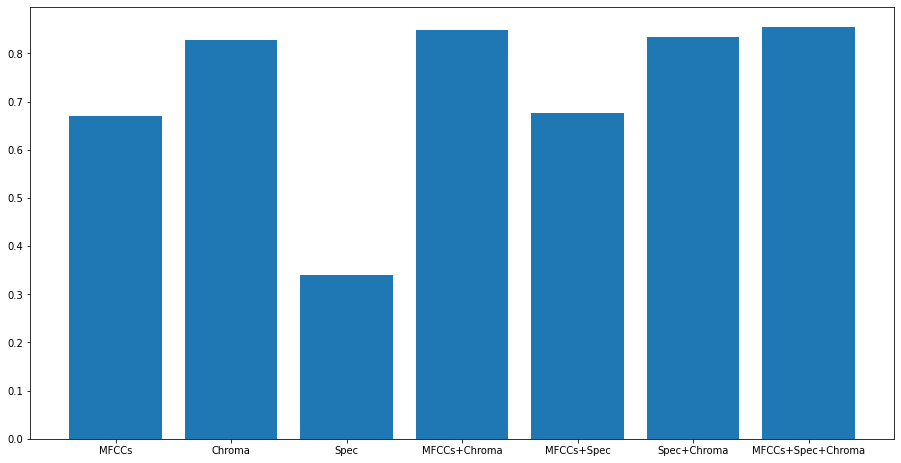

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features2]
accuracy_list = [x[0] for x in result_list2]
print(accuracy_list)
ax.bar(features,accuracy_list)
plt.show()

In [ ]:
print("We see a similar result as for the clean dataset")

print("\nFor",features2[3][0])
print("The classifier used is ",result_list2[3][-2]," with accuracy ",result_list2[3][-3])
print(result_list2[3][-1])

print("\nFor",features2[6][0])
print("The classifier used is ",result_list2[6][-2]," with accuracy ",result_list2[6][-3])
print(result_list2[6][-1])

print(" In this scenario, we can see that MFCCs+Chroma+spec perform better")

We see a similar result as for the clean dataset

For MFCCs+Chroma
The classifier used is  Naive Bayes  with accuracy  0.848
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       771
           1       0.68      0.79      0.73       791
           2       0.72      0.63      0.67       857
           3       0.95      0.91      0.93       785
           4       0.96      1.00      0.98       796

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000


For MFCCs+Spec+Chroma
The classifier used is  Naive Bayes  with accuracy  0.854
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       771
           1       0.68      0.80      0.74       791
           2       0.73      0.65      0.68       857
           3       0.96      0.92      0.94       785
           4       0.97      1.00 

# Support Vector Machines Implementation


In [ ]:
from sklearn.metrics import classification_report

from sklearn.svm import SVC
def SVMimplementation(X_train,X_test,y_train,y_test):
  parameters= {
    'C': [0.1, 1],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf','linear','sigmoid'],
    'cache_size':[1500],
    'max_iter': [10000]
  }
  final3 = GridSearchCV(estimator = SVC(),param_grid=parameters,scoring='accuracy',cv=5)
  final4 = final3.fit(X_train,y_train)

  list_predict = final4.predict(X_test)
  acc_score2 = accuracy_score(y_test,list_predict)
  report = classification_report(y_test,list_predict)
  return ((acc_score2,final4.best_params_['C'],final4.best_params_['kernel'],final4.best_params_['gamma'],'Support Vector Machine',report))


In [ ]:
# For the Clean Dataset 
# result_list = []
# for x in features1:

#   x_train = x[1]
#   x_test = x[2]
#   res = SVMimplementation(x_train,x_test,classes_train1,classes_test1)
#   result_list.append(res)
# For augmented
result_list2 = []
for x in features2:

  x_train = x[1]
  x_test = x[2]
  res = SVMimplementation(x_train,x_test,classes_train2,classes_test2)
  result_list2.append(res)

For Clean Dataset

[0.898, 0.851, 0.436, 0.95, 0.816, 0.786, 0.82]


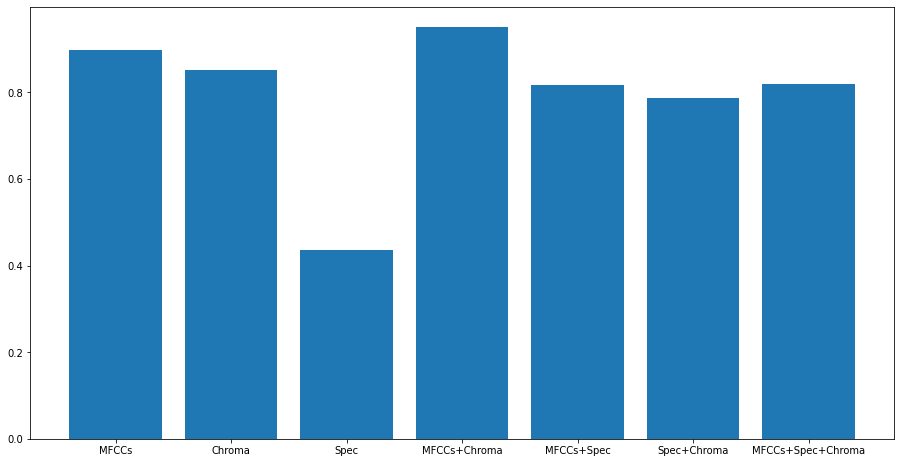

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features1]
accuracy_list = [x[0] for x in result_list]
print((accuracy_list))
ax.bar(features,accuracy_list)
plt.show()

In [ ]:
print("We can see that for SVM on the clean dataset , MFCCs + Chroma seem to work the best and they return the highest accuracy of ",max(accuracy_list))

print("\nFor",features[3][0])
print("The classifier used is ",result_list[3][-2]," with accuracy ",result_list[3][0], " the regularization parameter is ",result_list[3][3], " and the algorithm used is ",result_list[3][2], " the exponential function.")
print(result_list[3][-1])


We can see that for SVM on the clean dataset , MFCCs + Chroma seem to work the best and they return the highest accuracy of  0.95

For M
The classifier used is  Support Vector Machine  with accuracy  0.95  the regularization parameter is  0.01  and the algorithm used is  rbf  the exponential function.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       0.89      0.87      0.88       203
           2       0.87      0.90      0.88       194
           3       1.00      0.99      0.99       207
           4       1.00      1.00      1.00       192

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



For Clean and Augmented Dataset Combined

[0.9355, 0.887, 0.41325, 0.964, 0.796, 0.8595, 0.89825]


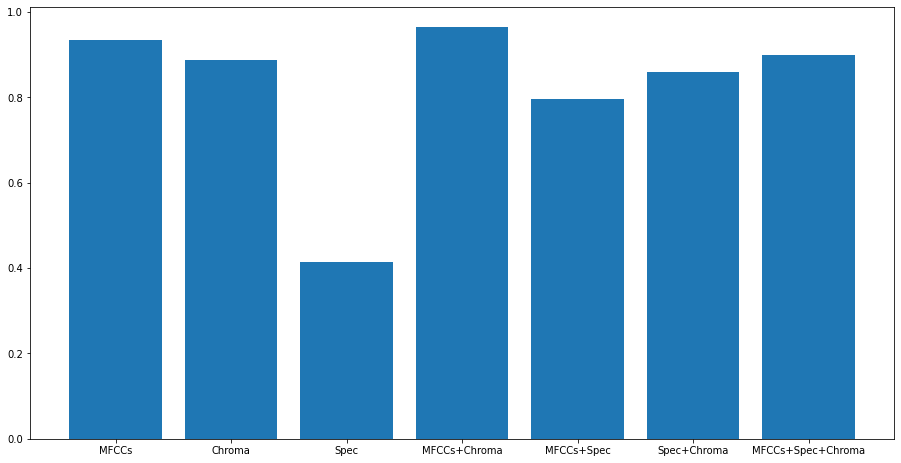

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features2]
accuracy_list = [x[0] for x in result_list2]
print(accuracy_list)
ax.bar(features,accuracy_list)
plt.show()

In [ ]:
print("We can see that for SVM on the Augmented and clean dataset combined , MFCCs + Chroma seem to work the best and they return the highest accuracy of ",max(accuracy_list))

print("\nFor",features2[3][0])
print("The classifier used is ",result_list2[3][-2]," with accuracy ",result_list2[3][0], " the regularization parameter is ",result_list2[3][3], " and the algorithm used is ",result_list2[3][2], " the exponential function.")
print(result_list2[3][-1])


We can see that for SVM on the Augmented and clean dataset combined , MFCCs + Chroma seem to work the best and they return the highest accuracy of  0.964

For MFCCs+Chroma
The classifier used is  Support Vector Machine  with accuracy  0.964  the regularization parameter is  0.1  and the algorithm used is  rbf  the exponential function.
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       792
           1       0.95      0.93      0.94       797
           2       0.93      0.93      0.93       816
           3       1.00      0.97      0.99       811
           4       0.94      1.00      0.97       784

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



# Neural Network Implementation

In [ ]:
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

def NeuralNetwork(X_train,X_test,y_train,y_test):
  parameters = {
    'learning_rate_init': [0.05, 0.01, 0.005, 0.001],
    'hidden_layer_sizes': [4, 8, 12],
    'activation': ["relu","logistic", "tanh"],
    'batch_size':[1000],
    'max_iter':[10000]}
  final3 = GridSearchCV(estimator=MLPClassifier(),param_grid=parameters,scoring='accuracy',cv=5)
  final4=final3.fit(X_train,y_train)
  predict_list= final4.predict(X_test)

  acc_score = accuracy_score(y_test,predict_list)
  report = classification_report(y_test,predict_list)
  return((acc_score,final4.best_params_['learning_rate_init'],final4.best_params_['hidden_layer_sizes'],final4.best_params_['activation'],'Neural Network',report))




In [ ]:
# For the Clean Dataset 
result_list = []
for x in features1:
  print(1)
  x_train = x[1]
  x_test = x[2]
  res = NeuralNetwork(x_train,x_test,classes_train1,classes_test1)
  result_list.append(res)
# For augmented
result_list2 = []
for x in features2:
  x_train = x[1]
  x_test = x[2]
  res = NeuralNetwork(x_train,x_test,classes_train2,classes_test2)
  result_list2.append(res)

In [ ]:
from pathlib import Path

path = Path('/content/drive/MyDrive/').expanduser()
# np.save(path/'result_nnFINAL',result_list)
# np.save(path/'result_nn2',result_list2)



result_list =np.load(path/'result_nnFINAL.npy')
result_list2 =np.load(path/'result_nn2.npy')


For the Clean Dataset


[0.882 0.859 0.203 0.94  0.807 0.722 0.936]


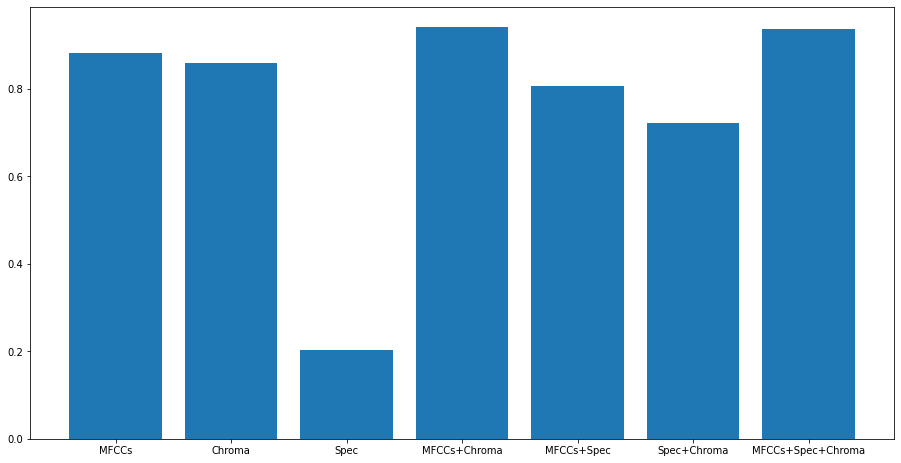

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features1]
accuracy_list = [x[0] for x in result_list]
accuracy_list = np.array(accuracy_list,dtype=float)

# accuracy_list = [(x[0]*100) for x in result_list]
print((accuracy_list))
ax.bar(features,accuracy_list)
plt.show()

In [ ]:
print("As a somewhat excpetcted result, we see that MFCCs + Chromagram are the best features in terms of accuracy for neural networks")
print("This is expected because from the previous classifiers we ran  we found that")
print("MFCCs+Chroma perform the best together")

print("\nFor",features1[3][0])
print("The classifier used is ",result_list[3][-2]," with accuracy ",result_list[3][0], ", the initial learning rate is ",result_list[3][1], " and the number of hidden layers used is ",result_list[3][2], "\nwith the activation function: ",result_list[3][3])
print(result_list2[6][-1])


As a somewhat excpetcted result, we see that MFCCs + Chromagram are the best features in terms of accuracy for neural networks
This is expected because from the previous classifiers we ran  we found that
MFCCs+Chroma perform the best together

For MFCCs+Chroma
The classifier used is  Neural Network  with accuracy  0.94 , the initial learning rate is  0.001  and the number of hidden layers used is  12 
with the activation function:  relu
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       807
           1       0.79      0.87      0.83       787
           2       0.86      0.79      0.83       799
           3       0.98      0.97      0.98       845
           4       1.00      1.00      1.00       762

    accuracy                           0.92      4000
   macro avg       0.93      0.92      0.92      4000
weighted avg       0.93      0.92      0.92      4000



For the augmented and Clean dataset combined


[0.8805  0.84425 0.1905  0.94625 0.60875 0.76925 0.92475]


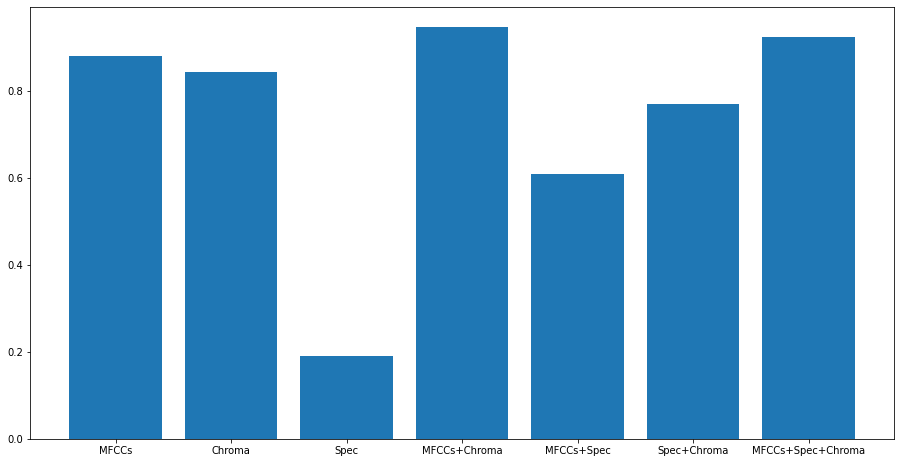

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1.5])
features = [x[0] for x in features2]
accuracy_list = [x[0] for x in result_list2]
accuracy_list = np.array(accuracy_list,dtype=float)
print((accuracy_list))
ax.bar(features,accuracy_list)
plt.show()

In [ ]:
print("Again, we see that MFCCs+Chroma Perform the best together")
print("\nFor",features2[3][0])
print("The classifier used is ",result_list2[3][-2]," with accuracy ",result_list2[3][0], ", the initial learning rate is ",result_list2[3][1], " and the number of hidden layers used is ",result_list2[3][2], "\nwith the activation function: ",result_list2[3][3])
print(result_list2[3][-1])

Again, we see that MFCCs+Chroma Perform the best together

For MFCCs+Chroma
The classifier used is  Neural Network  with accuracy  0.94625 , the initial learning rate is  0.005  and the number of hidden layers used is  12 
with the activation function:  relu
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       807
           1       0.86      0.88      0.87       787
           2       0.89      0.86      0.87       799
           3       0.99      0.99      0.99       845
           4       1.00      1.00      1.00       762

    accuracy                           0.95      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.95      0.95      0.95      4000



# Further Analysis


Text(0, 0.5, 'Amplitude')

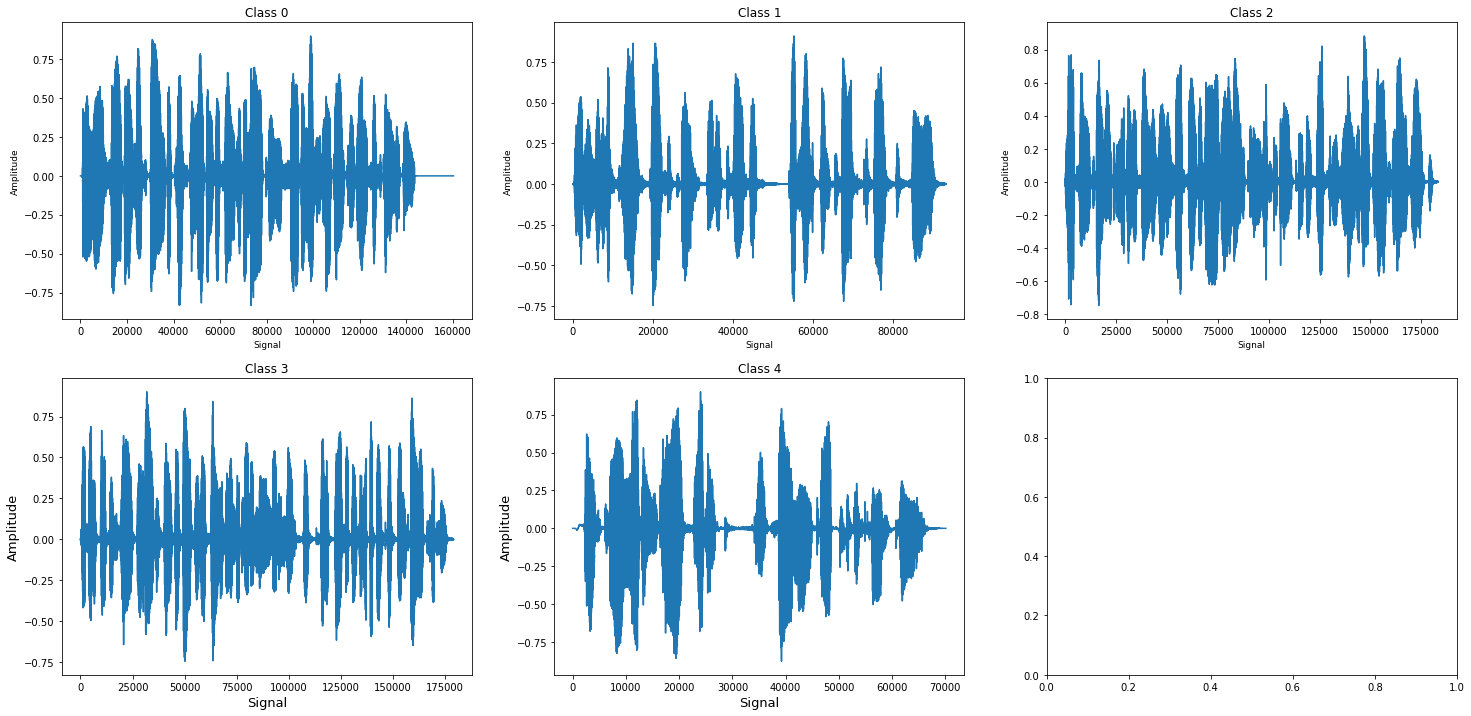

In [ ]:
#0th element is class 1, first is 4, 2nd is class2, third is class 0, fourth is class 3

# def plot(vector, name, xlabel=None, ylabel=None)
import matplotlib.pyplot as plt
signal, sr = librosa.load(aud_list[3])
y0 = signal
signal, sr = librosa.load(aud_list[0])
y1 = signal
signal, sr = librosa.load(aud_list[2])
y2 = signal
signal, sr = librosa.load(aud_list[4])
y3 = signal
signal, sr = librosa.load(aud_list[1])
y4 = signal

figure, axis = plt.subplots(2, 3,figsize=(25,12))

axis[0, 0].plot(y0)
axis[0, 0].set_title("Class 0")
axis[0, 1].plot(y1)
axis[0, 1].set_title("Class 1")
axis[0, 2].plot(y2)
axis[0, 2].set_title("Class 2")
axis[1, 0].plot(y3)
axis[1, 0].set_title("Class 3")
axis[1, 1].plot(y4)
axis[1, 1].set_title("Class 4")


axis[0,0].set_xlabel("Signal",fontsize=9)
axis[0,0].set_ylabel("Amplitude",fontsize=9)

axis[0,1].set_xlabel("Signal",fontsize=9)
axis[0,1].set_ylabel("Amplitude",fontsize=9)

 
axis[0,2].set_xlabel("Signal",fontsize=9)
axis[0,2].set_ylabel("Amplitude",fontsize=9)


axis[1,0].set_xlabel("Signal",fontsize=13)
axis[1,0].set_ylabel("Amplitude",fontsize=13)


axis[1,1].set_xlabel("Signal",fontsize=13)
axis[1,1].set_ylabel("Amplitude",fontsize=13)



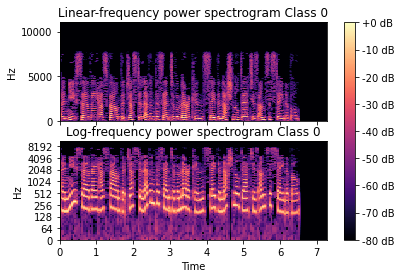

In [ ]:
import matplotlib.pyplot as plt
y, sr = librosa.load(aud_list[3], duration=15)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram Class 0')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram Class 0')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

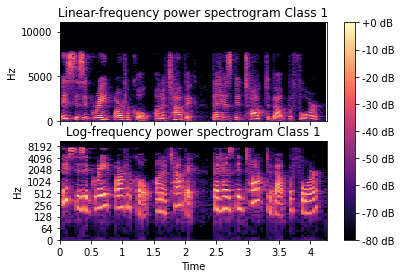

In [ ]:
import matplotlib.pyplot as plt
y, sr = librosa.load(aud_list[0], duration=15)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram Class 1')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram Class 1')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

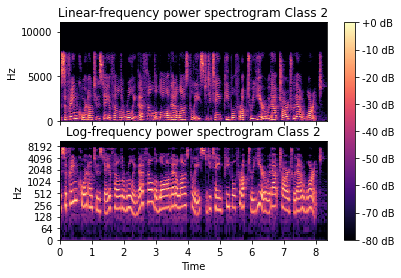

In [ ]:
import matplotlib.pyplot as plt
y, sr = librosa.load(aud_list[2], duration=15)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram Class 2')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram Class 2')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

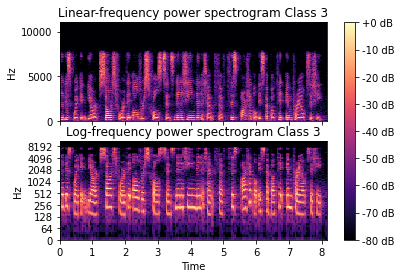

In [ ]:
import matplotlib.pyplot as plt
y, sr = librosa.load(aud_list[4], duration=15)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram Class 3')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram Class 3')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

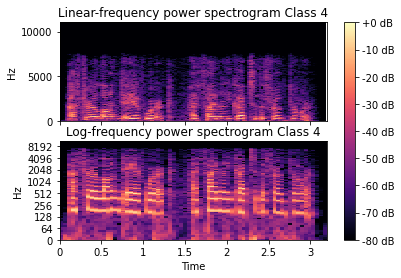

In [ ]:
import matplotlib.pyplot as plt
y, sr = librosa.load(aud_list[1], duration=15)
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=sr, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram Class 4')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=sr, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram Class 4')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")